# GP Classifier

In [1]:
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
from typing import *

## Inputs 

Input to Algorithm 3.1

### Train Data

In [2]:
num_samples = 10
dim = 2

X = np.random.uniform(low=-2, high=2, size=(num_samples,dim))

# random classes in {-1, +1}
# y = np.random.randint(low=0, high=2, size=(num_samples,)) * 2 - 1

# some dependence between X and y
y = np.logical_or(X[:, 0] > .5, X[:, 1] > 1).astype(np.int32) * 2 - 1

In [3]:
X, y

(array([[-1.54178536,  1.32825393],
        [ 1.48954673, -1.88001572],
        [-1.53921437, -1.36518591],
        [-0.80728953, -1.29468165],
        [ 0.4052538 , -1.39020181],
        [ 1.21222121,  1.77913962],
        [-1.76656821, -0.92424771],
        [ 0.84750055,  1.1676595 ],
        [ 1.35192151, -0.43762404],
        [-1.91327833, -1.1443156 ]]),
 array([ 1,  1, -1, -1, -1,  1, -1,  1,  1, -1], dtype=int32))

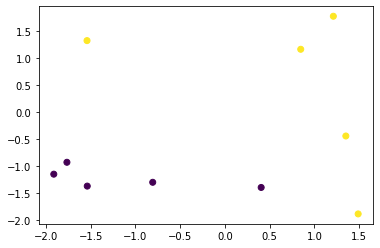

In [4]:
plt.scatter(*X.T, c=y)

In [5]:
X_test = np.mgrid[-3:3.01:0.25, -3:3.01:0.25].reshape(2,-1).T
# np.linspace(start=-3, stop=3, num=100)
X_test

array([[-3.  , -3.  ],
       [-3.  , -2.75],
       [-3.  , -2.5 ],
       ...,
       [ 3.  ,  2.5 ],
       [ 3.  ,  2.75],
       [ 3.  ,  3.  ]])

### Kernel "Squared-Exponential Covariance Function"

~~Eq. (2.16) from the book~~ Eq. 2.31 from the book (and for multi-dimensional see [here](https://stats.stackexchange.com/a/362537/249793)).

In [6]:
def se_y_onedim(x_p: float, x_q: float, l: float, sigma_f: float) -> float:
    return sigma_f ** 2 * np.exp(-((x_p - x_q) ** 2) / (2.0 * l ** 2))

def se_y(x_p: np.ndarray, x_q: np.ndarray, l: float, sigma_f: float) -> float:
    return sigma_f ** 2 * np.exp(-.5 * np.sum(((x_p - x_q) / l) ** 2))

def se(x_p: np.ndarray, x_q: np.ndarray, l: float, sigma_f: float) -> float:
    f = partial(se_y, l=l, sigma_f=sigma_f)
    
    return np.array(
        [
            [f(x_p[i], x_q[j]) for j in range(x_q.shape[0])] 
            for i in range(x_p.shape[0])
        ]
    )

In [7]:
kernel = partial(se, l=.01, sigma_f=1)

### Covariance matrix

See also [page 105 here](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf).

In [8]:
noise_scale = 0

# K in the book; input to Algorithm 3.1
kXX = kernel(X, X)  # sigma_bb

# K* in the book
kxX = kernel(X_test, X)  # sigma_ab and sigma_ba

kxx = kernel(X_test, X_test)  # sigma_aa

m_pre = np.linalg.inv(kXX + noise_scale**2 * np.eye(X.shape[0]))

mpost = kxX @ m_pre @ y
vpost = kxx - kxX @ m_pre @ kxX.T

spost = np.random.multivariate_normal(mpost.flatten(), vpost, size=10).T

In [9]:
mpost.shape

(625,)

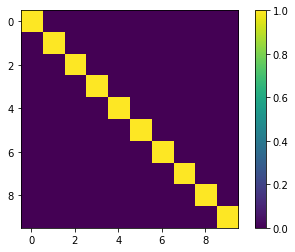

In [10]:
plt.imshow(kXX)
plt.colorbar()
plt.show()

### Likelihood function

$p(\boldsymbol{y}\mid\boldsymbol{f})$

(Equation 3.5; using logit sigmoid function here)  
$\log p(y_i\mid f_i) = \log\sigma(y_i\times f_i) = -\log(1 + \exp(-y_i f_i))$

$p(y\mid f)=\sigma(f_iy_i)$

$\nabla\sigma(z)=\sigma(z)\times(1-\sigma(z))$  
$\nabla\nabla\sigma(z)=\sigma(z)\times(1-\sigma(z))\times(1-\sigma(z))+\sigma(z)\times-\sigma(z)\times(1-\sigma(z))$ substitute $\pi=\sigma(z)$

(Equation 3.15)  
$\nabla\nabla\sigma(z)=\pi\times(1-\pi)\times(1-\pi)+\pi\times-\pi\times(1-\pi)=\pi\times(1-\pi)$

Second derivative $\nabla\nabla\log p(y_i\mid f_i) = -\pi_i\times(1-\pi_i)$ with $\pi_i=p(y_i=1\mid f_i)$

$p(y\mid f)=\Pi_i(p(y_i\mid f_i))=\Pi_i(\sigma(y_i\times f_i))$

$\log$ for sum

In [11]:
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))

# for logistic regression we'd have the following
# but we don't have weights here
# def f_fn(x: np.ndarray, w: np.ndarray) -> np.ndarray:
#     return sigmoid(np.dot(x, w))

In [12]:
def log_likelihood(f: np.ndarray, y: np.ndarray):
    return np.sum(list(sigmoid(f_i * y_i) for f_i, y_i in zip(f, y)))

In [13]:
log_likelihood(np.array([-2, 10, -4]), np.array([-1, 1, -1]))

2.8627654701470884

---

At this point all inputs to Algorithm 3.1 are available. Below are some loose notes.

In [14]:
sigma = np.eye(dim)
mean = np.zeros(dim)
sigma, mean

(array([[1., 0.],
        [0., 1.]]),
 array([0., 0.]))

In [15]:
w = np.random.multivariate_normal(mean=mean, cov=sigma)
w

array([ 1.521095  , -0.31224896])

In [16]:
X

array([[-1.54178536,  1.32825393],
       [ 1.48954673, -1.88001572],
       [-1.53921437, -1.36518591],
       [-0.80728953, -1.29468165],
       [ 0.4052538 , -1.39020181],
       [ 1.21222121,  1.77913962],
       [-1.76656821, -0.92424771],
       [ 0.84750055,  1.1676595 ],
       [ 1.35192151, -0.43762404],
       [-1.91327833, -1.1443156 ]])

**General note:**

* $Ax = b$ --> $O(n^2 + n)$ (?) but numerically stable
* $x = A^{-1}b$ --> $O(n^3)$ numerically instable

_On line 7 in Algorithm 3.1:_

Instead of solving $Ax=b$ we run $L:=\operatorname{cholesky}(A)$ and solve for $LL^Tx=b$

---

$L\underbrace{\left(L^Tx\right)}_z=b$

$L$ is a lower-triangular matrix.

$z:=L^Tx$

Solve $Lz=b$, once we got $z$ we solve $L^Tx=z$.

Example

```
A = [[1, 2], [3, 4]]
LL^T := A

A[1][1] = L[1][1]*L[1][1] + L[1][1]*L[1][2] + ...
# gives n^2 equations (one for each entry in the L matrix)
```

### Prediction

In [17]:
from scipy.linalg import cho_solve, cho_factor

In [18]:
G = kXX + noise_scale ** 2 * np.eye(X.shape[0])

In [19]:
# with Cholesky
L = cho_factor(G)
A = cho_solve(L, kxX.T).T

In [20]:
# alternative (w/o Cholesky)
# kxX.shape = [num_test X_test.shape[0], num_train X.shape[0]]
# AG = kxX
# G^TA^T = kxX^t
# cholesky(G^T) = L^TL
# L^T @ (L @ A^T) = kxX^T
# L^T @ z = kxX^T  (solve this first)  # corresponds to 'A = cho_solve(L, kxX.T).T'
# L @ A&^T = z

A = kxX @ np.linalg.inv(G)

In [21]:
# mpost = mean_function(X_test) + A @ (Y - mean_function(X))
# vpost = kernel(X_test, X_test) - A @ kxX.T

# mpost = mx + A @ (Y - mX)
# vpost = kxx - A @ kxX.T

We want to maximize $p(f\mid X, y)$ (from Eq. 3.9). It is proportional to

$$\displaystyle p(y\mid f)p(f\mid X)\,.$$


We can take the log of the function we want to maximize:

$\max_f\quad\ln \underbrace{p(y\mid f)}_{\text{likelihood}}+\ln \underbrace{p(f\mid X)}_\text{prior}$

The **likelihood** factorizes: $\Pi_i p(y_i\mid f_i)=\Pi_i \sigma(y_i f_i)$; $f$ are the _parameters_ (here function values) over which we optimize.

The log of the likelihood is a sum: $\ln\Pi_i \sigma(y_i f_i)=\sum_i \ln\sigma(y_i f_i)$. This is a concrete function, the derivative and second derivative are known (see Eq. 3.15), so we can optimize it.

The **prior** $p(f\mid X)$ is a normal distribution with mean 0 and variance $K$ (`kXX`) (see Eq. 3.12 on the right-hand side).

## Algorithm 3.1 / Equation 3.9

In [22]:
arr = np.ndarray

In [23]:
sqrt_elem = np.vectorize(np.sqrt)
sigmoid_elem = np.vectorize(sigmoid)

In [24]:
def algorithm_31(K: arr, y: arr, log_likelihood_fn: Callable[[arr, arr], arr], eps: float) -> Tuple[arr, arr]:
    n = y.shape[0]
    f = np.zeros_like(y)
    converged = False
    prev_obj = 0
    
    while not converged:
        W = -np.diag([-sigmoid(f_i * y_i) * (1 - sigmoid(f_i * y_i)) for f_i, y_i in zip(f, y)])  # line 4
        G = np.eye(n) + sqrt_elem(W) @ K @ sqrt_elem(W)  # line 5 a
        L, lower = cho_factor(G, lower=True)  # line 5 b
        
        b = W @ f + (y + 1) / 2 - sigmoid_elem(f * y)  # line 6; Eq. 3.15
        # A\b --> Ax = b --> cho_solve(cho_factor(A), b)
        
        # line 7
        z2 = cho_solve((L, lower), sqrt_elem(W) @ K @ b)
        z1 = cho_solve((L.T, lower), z2)
        a = b - sqrt_elem(W) @ z1
        
        f = K @ a  # line 8
        
        obj = -.5 * a.T @ f + log_likelihood_fn(f, y)  # line 9 (right)
        print(obj)
        converged = abs(obj - prev_obj) < eps    # line 9 (left)
        prev_obj = obj
    
    # log likelihood = p(y | X, theta) aka. quality of the fit
    approx_log_marginal_likelihood = obj - np.trace(np.log(L))  # line 10
    f_hat = f  # mpost
    return f_hat, approx_log_marginal_likelihood

In [25]:
out = algorithm_31(K=kXX, y=y, log_likelihood_fn=log_likelihood, eps=.001)
f_hat, approx_log_marginal_likelihood = out
f_hat, approx_log_marginal_likelihood

5.152832498647262
4.915566076053829
4.779397877535402
4.722542593760887
4.701018845574984
4.693143811118933
4.690297288419423
4.689272842141747
4.688904724468819


<ipython-input-24-969424b8df4b>:28: RuntimeWarning: divide by zero encountered in log
  approx_log_marginal_likelihood = obj - np.trace(np.log(L))  # line 10


(array([ 0.41958446,  0.41958446, -0.70159676, -0.70159676, -0.70159676,
         0.41958446, -0.70159676,  0.41958446,  0.41958446, -0.70159676]),
 3.652099950582124)

$\hat{f}$ has greater values where $y=1$

In [26]:
list(zip(f_hat, y))

[(0.41958445565421837, 1),
 (0.41958445565421837, 1),
 (-0.701596758626942, -1),
 (-0.701596758626942, -1),
 (-0.701596758626942, -1),
 (0.41958445565421837, 1),
 (-0.701596758626942, -1),
 (0.41958445565421837, 1),
 (0.41958445565421837, 1),
 (-0.701596758626942, -1)]

In [27]:
list(zip((round(sigmoid(f_i) * 2 - 1, 4) for f_i in f_hat), y))

[(0.2068, 1),
 (0.2068, 1),
 (-0.3371, -1),
 (-0.3371, -1),
 (-0.3371, -1),
 (0.2068, 1),
 (-0.3371, -1),
 (0.2068, 1),
 (0.2068, 1),
 (-0.3371, -1)]

## Algorithm 3.2 / Equation 3.10

In [28]:
def algorithm_32(
    f_hat: arr, X: arr, y: arr, k: Callable, log_likelihood_fn: Callable[[arr, arr], arr], x_test: arr
) -> arr:
    """
    Algorithm 3.2: Predictions for binary Laplace GPC.
    f_hat: mode (from Algorithm 3.1)
    X: inputs
    y: +-1 targets
    k: covariance function (kernel)
    log_likelihood_fn: log likelihood function
    x_test: test input
    """
    W = -np.diag([-sigmoid(f_i * y_i) * (1 - sigmoid(f_i * y_i)) for f_i, y_i in zip(f_hat, y)])  # line 2
    G = np.eye(n) + sqrt_elem(W) @ K @ sqrt_elem(W)  # line 3 a
    L, lower = cho_factor(G, lower=True)  # line 3 b
    f_bar_star = kernel(x_test, X).T @ (y + 1) / 2 - sigmoid_elem(f_hat * y)  # line 4; Eq. 3.15

    v = cho_solve((L, lower), sqrt_elem(W) @ kernel(x_test, X))  # line 5
    V_f_star = kernel(x_test, x_test) - v.T @ v  # line 6
    # TODO # line 7
    return # line 8

In [ ]:
pi_bar_star = algorithm_32(f_hat=f_hat, X=X, y=y, k=kernel, log_likelihood_fn=log_likelihood, x_test=X_test)